### Imports

In [1]:
import matplotlib.pyplot as plt
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

from torchvision import datasets, transforms

import os
import spect

### Load Data

In [2]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
use_mnist=False

In [3]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

if use_mnist:
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)


    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)
else:
    dir_ = "/mnt/pccfs/backed_up/andrew/hearables/clean/"
    data = []
#     for filename in os.listdir(dir_):
    for i in range(1000):
        f, t, zxx, sample_rate = spect.get_stft(dir_ + "nwords_243.wav", split=True)
        data.append([f, t, torch.tensor(zxx), sample_rate])
#     data = torch.tensor([spect.get_stft(dir_ + x, split=True) for x in os.listdir(dir_)])
    np.random.shuffle(data)
    train_loader = data[:998]
    test_loader = data[998:]
    


### Helper functions

In [4]:
def get_context_points_audio(data, context_points=100):
    
    mask = np.zeros_like(data[0])
    
    n,m = mask.shape
    mask = mask.reshape(-1)

    mask[:context_points] = 1
    np.random.shuffle(mask)

    mask = mask.reshape(n,m)
    
    data = np.array(data.tolist())

    data[0][mask != 1] = 0
    data[1][mask != 1] = 0

    data = torch.tensor(data)
    
    return data

def get_context_points_mnist(data, context_points=100):
    
    mask = np.zeros_like(data[0, 0])
    
    n,m = mask.shape
    mask = mask.reshape(-1)

    mask[:context_points] = 1
    np.random.shuffle(mask)

    mask = mask.reshape(n,m)
    
    data = np.array(data.tolist())

    data[0, 0][mask != 1] = 0

    data = torch.tensor(data)
    
    return data

def normalize(x):
    x = (x - x.min())/(x.max() - x.min())
    return x

def get_log_p(data, mu, sigma):
    return -torch.log(torch.sqrt(2*math.pi*sigma**2)) - (data - mu)**2/(2*sigma**2)

In [5]:
class FCEncoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,128)
        

    def forward(self, x):
        
        # this gets the x,y coordinates of the zero values
        cntx = x[0].nonzero()[:,[-2,-1]]
        
        x_points = cntx[:,0]
        y_points = cntx[:,1]
        
        # we then need to pull out real, imag intensities
        real = x[0][x_points, y_points]
        imag = x[1][x_points, y_points]

        x = torch.stack((normalize(x_points.float()), normalize(y_points.float()), real.reshape(-1), imag.reshape(-1)))
        
        x.transpose_(0,1)
        output = torch.empty((x.shape[0], 128)).to(device)
        
        # aggregate all outputs of intensity data found in x at the various context points
        for i, row in enumerate(x):
            output[i] = self.fc3(F.relu(self.fc2(self.fc1(row))))
        
        output = output.mean(0) # aggregation
        return output
    
class FCDecoder(nn.Module):
    def __init__(self, m,n):
        super(Decoder, self).__init__()
        self.m = m
        self.n = n
        self.fc1 = nn.Linear(130, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 4) # output the number of parameters you want. 2 for mu/sigma 4 for 2d mu/sigma

    def forward(self, r):

        # we only take in r, because in this case x is all points in size of image (n, m)
        x = torch.tensor([[i, j] for i in range(0,self.m) for j in range(0,self.n)]).float().to(device)
        x = torch.cat((x, r.view(1,-1).repeat(1,self.m*self.n).view(self.m*self.n,128)), 1)
        
        h = self.fc4(F.relu(self.fc3(F.relu(self.fc2(F.relu(self.fc1(x)))))))
        
        mu_real = h[:,0]
        log_sigma_real = h[:,1]
        
        mu_imag = h[:,2]
        log_sigma_imag = h[:,3]
        
        # bound the variance
        sigma_real = 0.1 + 0.9 * F.softplus(log_sigma_real)
        sigma_imag = 0.1 + 0.9 * F.softplus(log_sigma_imag)
        
        return mu_real, sigma_real, mu_imag, sigma_imag



In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,128)
        

    def forward(self, x):
        
        # this gets the x,y coordinates of the zero values
        cntx = x[0].nonzero()[:,[-2,-1]]
        
        x_points = cntx[:,0]
        y_points = cntx[:,1]
        
        # we then need to pull out real, imag intensities
        real = x[0][x_points, y_points]
        imag = x[1][x_points, y_points]

        x = torch.stack((normalize(x_points.float()), normalize(y_points.float()), real.reshape(-1), imag.reshape(-1)))
        
        x.transpose_(0,1)
        output = torch.empty((x.shape[0], 128)).to(device)
        
        # aggregate all outputs of intensity data found in x at the various context points
        for i, row in enumerate(x):
            output[i] = self.fc3(F.relu(self.fc2(self.fc1(row))))
        
        output = output.mean(0) # aggregation
        return output
    
class Decoder(nn.Module):
    def __init__(self, m,n):
        super(Decoder, self).__init__()
        self.m = m
        self.n = n
        self.fc1 = nn.Linear(130, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 4) # output the number of parameters you want. 2 for mu/sigma 4 for 2d mu/sigma

    def forward(self, r):

        # we only take in r, because in this case x is all points in size of image (n, m)
        x = torch.tensor([[i, j] for i in range(0,self.m) for j in range(0,self.n)]).float().to(device)
        x = torch.cat((x, r.view(1,-1).repeat(1,self.m*self.n).view(self.m*self.n,128)), 1)
        
        h = self.fc4(F.relu(self.fc3(F.relu(self.fc2(F.relu(self.fc1(x)))))))
        
        mu_real = h[:,0]
        log_sigma_real = h[:,1]
        
        mu_imag = h[:,2]
        log_sigma_imag = h[:,3]
        
        # bound the variance
        sigma_real = 0.1 + 0.9 * F.softplus(log_sigma_real)
        sigma_imag = 0.1 + 0.9 * F.softplus(log_sigma_imag)
        
        return mu_real, sigma_real, mu_imag, sigma_imag



### Hyperparameters

In [7]:
m,n = 129,1252 #28, 28
num_pixels = m*n

batch_size = 1
test_batch_size = 1000
epochs = 10

log_interval = 500


min_context_points = num_pixels * 0.05 # always have at least 5% of all pixels
max_context_points = num_pixels * 0.95 # always have at most 95% of all pixels

### Train

Loss: 5.174973 Mean: 2.6497209072113037/-2.287773370742798 Sig: 181.89187622070312/0.17795808613300323: : 998it [15:48:41, 57.04s/it]  


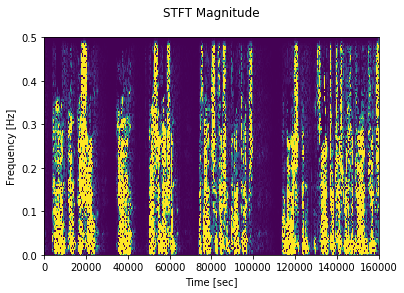

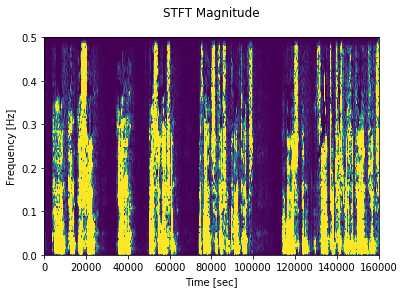

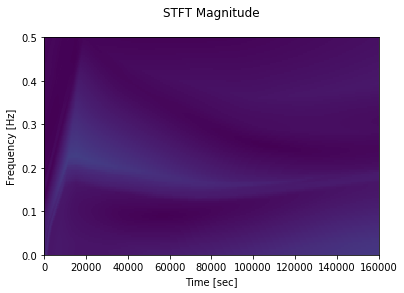

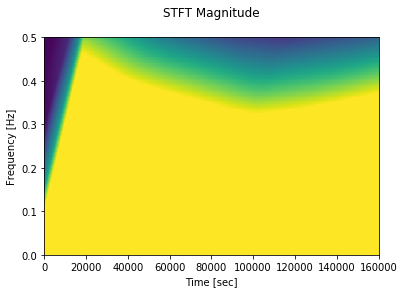

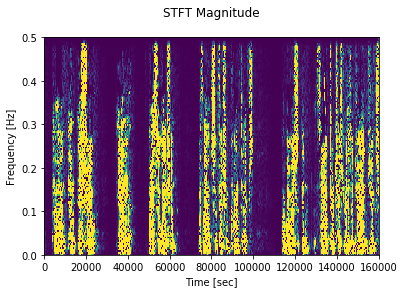

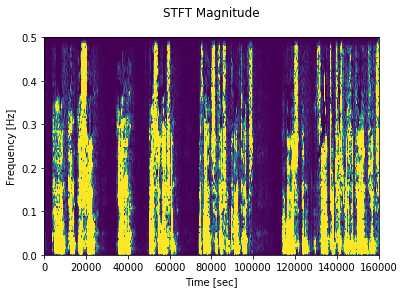

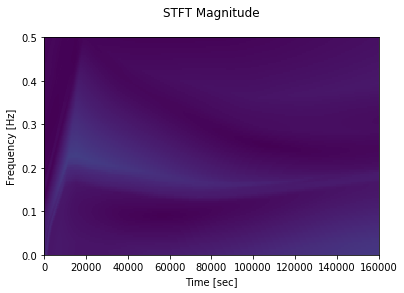

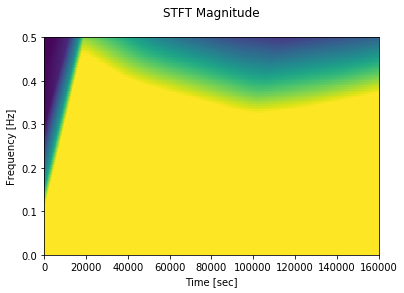

Loss: 5.034233 Mean: 2.5914628505706787/-3.5678136348724365 Sig: 274.3515319824219/0.200520321726799: : 998it [15:15:05, 55.02s/it]


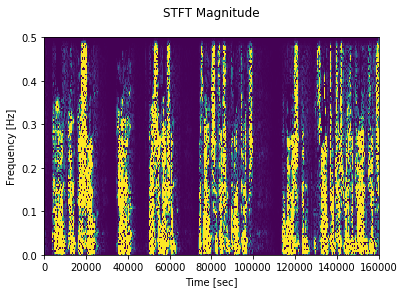

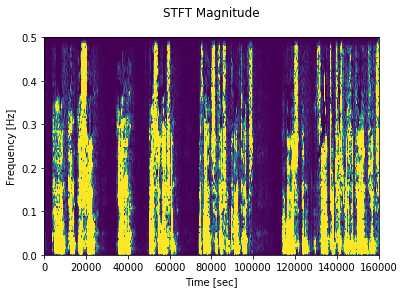

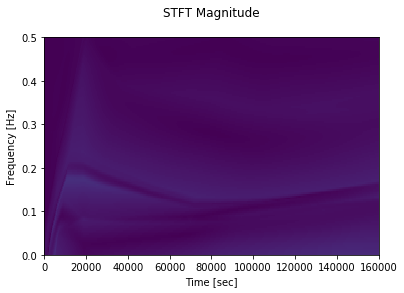

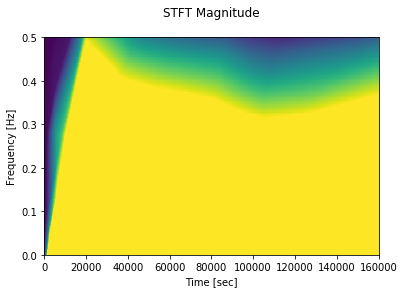

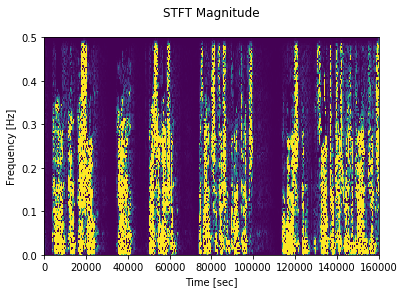

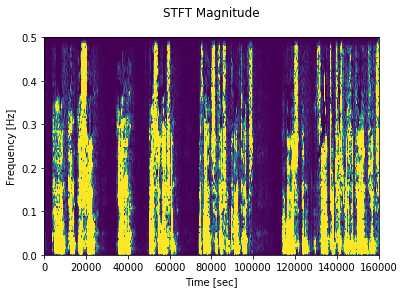

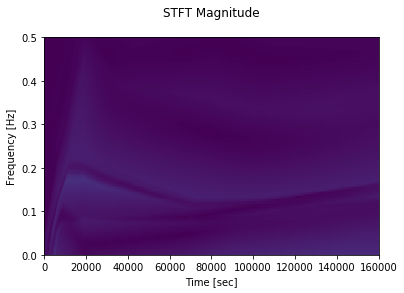

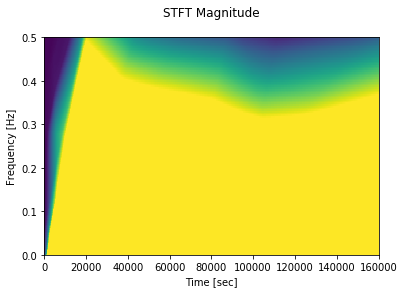

Loss: 4.980145 Mean: 4.272101402282715/-5.689239501953125 Sig: 330.93798828125/0.2108762562274933: : 998it [15:52:21, 57.26s/it]   


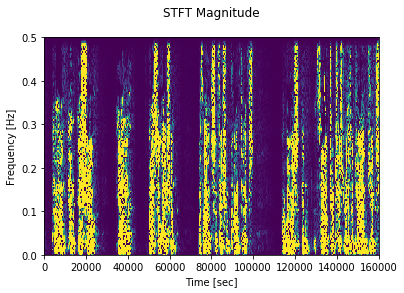

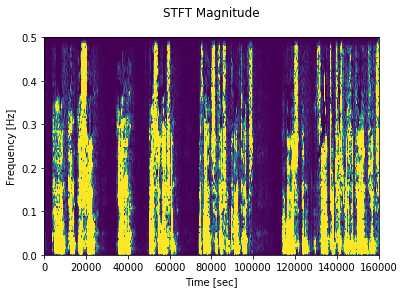

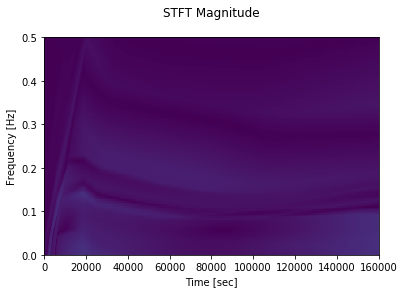

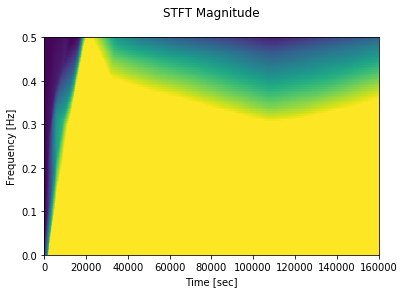

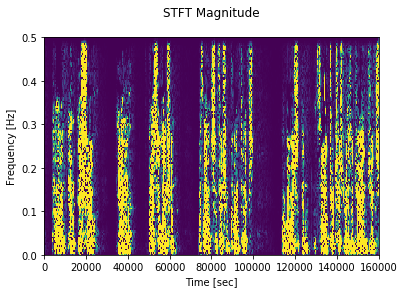

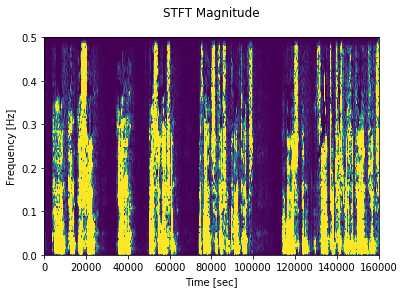

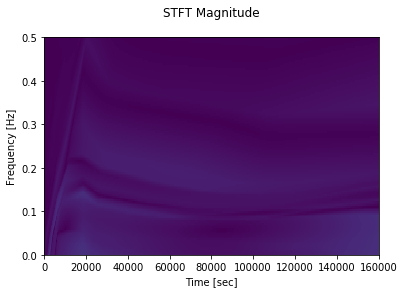

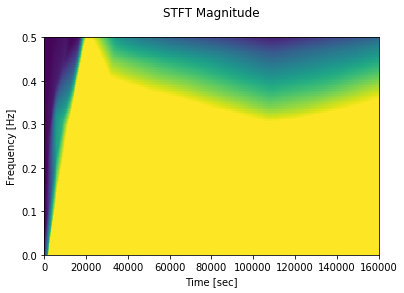

Loss: 4.978975 Mean: 4.566335201263428/-5.122401714324951 Sig: 378.55322265625/0.13364337384700775: : 998it [15:21:45, 55.42s/it]   


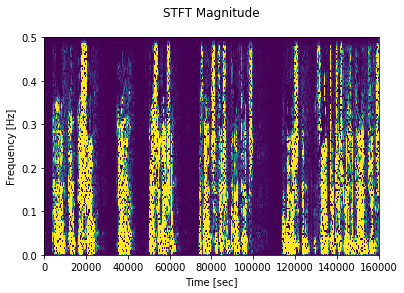

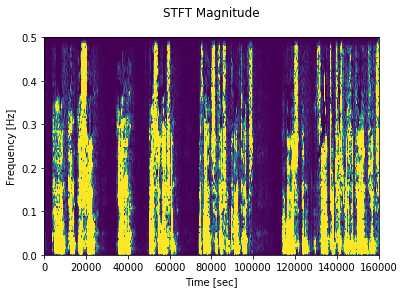

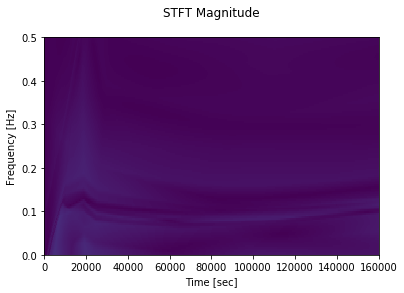

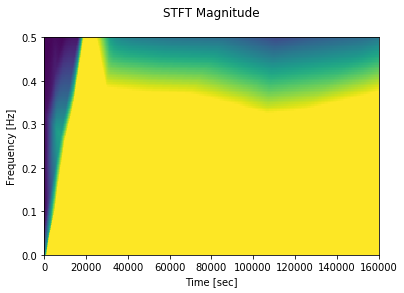

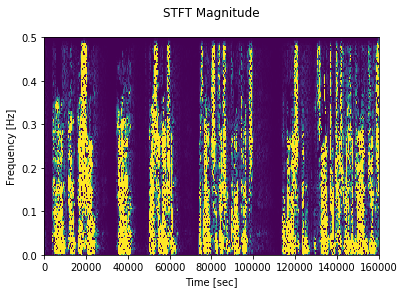

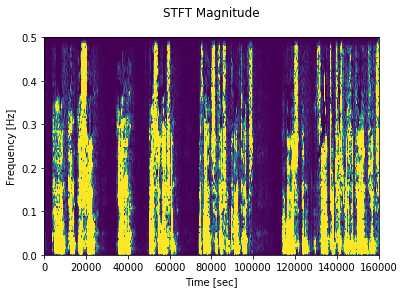

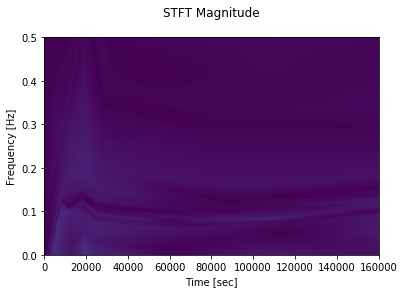

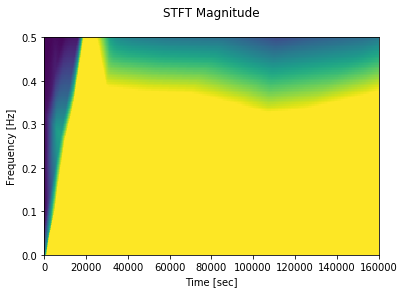

Loss: 4.922782 Mean: 4.720993995666504/-2.324125051498413 Sig: 412.39154052734375/0.1908622533082962: : 998it [15:13:15, 54.91s/it]


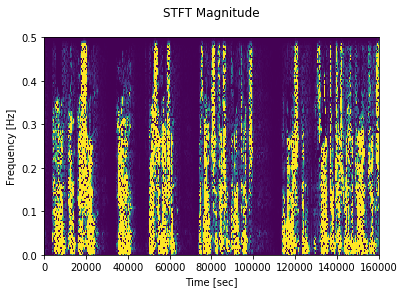

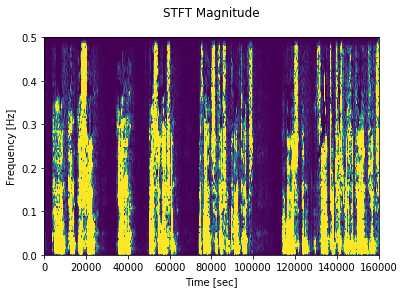

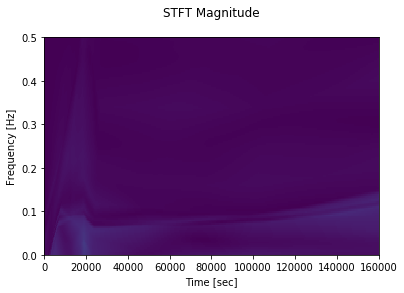

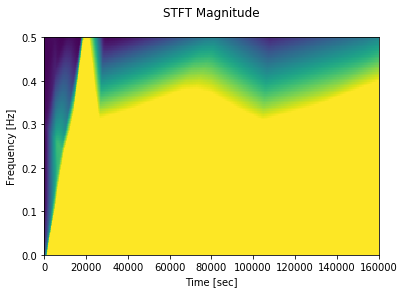

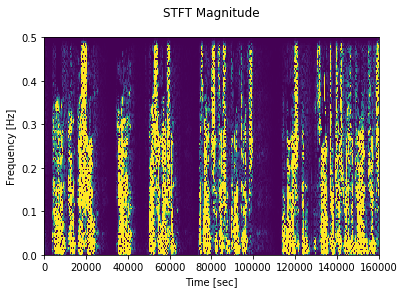

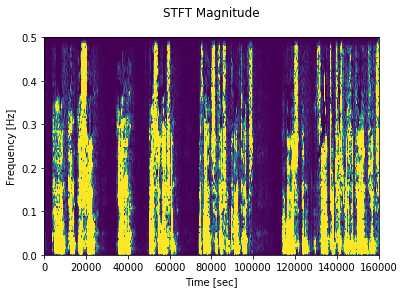

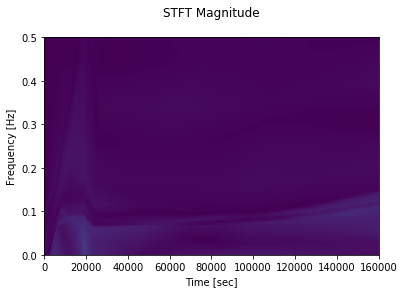

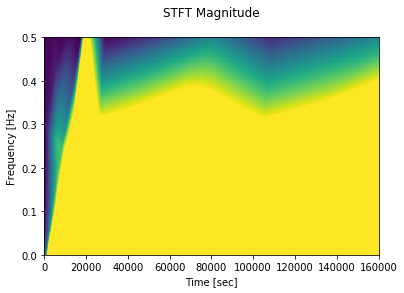

Loss: 4.817595 Mean: 2.9103524684906006/-4.258352279663086 Sig: 421.3055725097656/0.10003579407930374: : 998it [15:03:49, 54.34s/it]


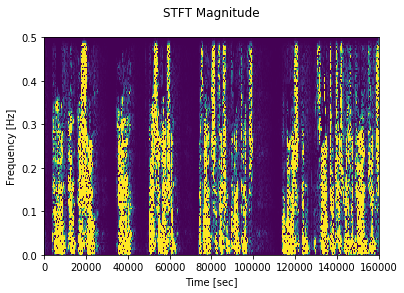

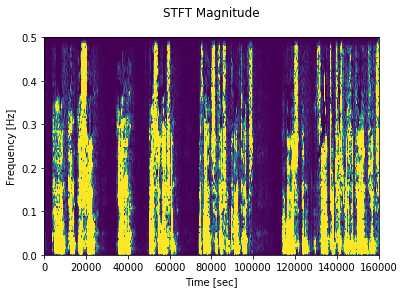

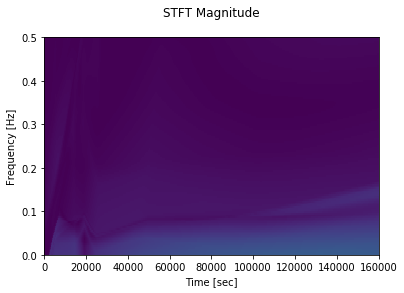

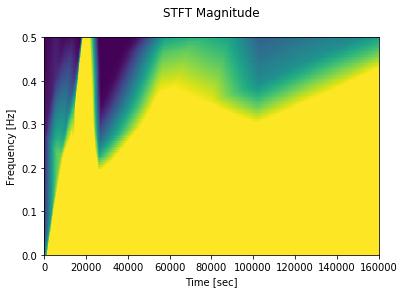

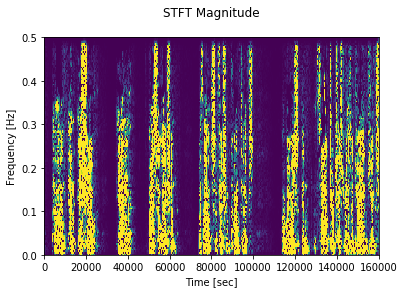

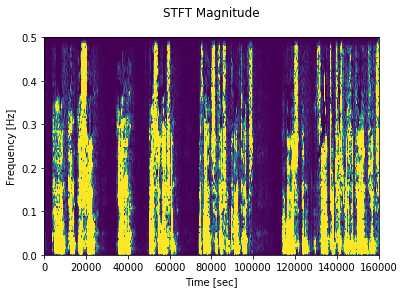

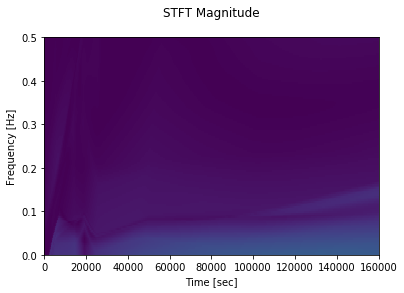

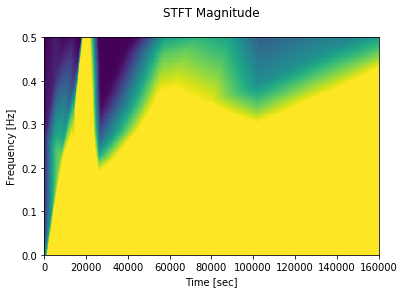

Loss: 4.738927 Mean: 4.091795444488525/-1.6824226379394531 Sig: 464.9373474121094/0.10001354664564133: : 998it [15:27:32, 55.76s/it]


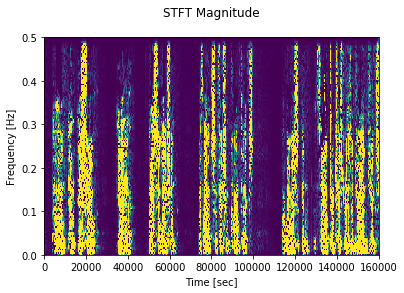

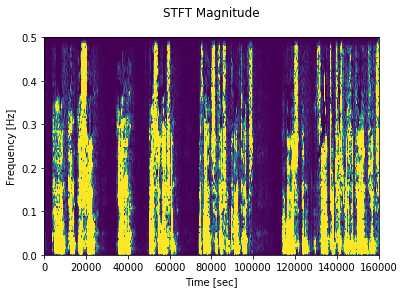

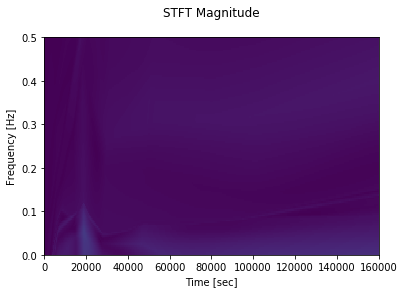

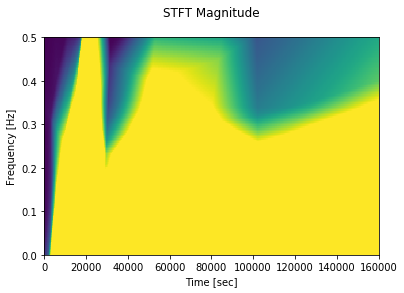

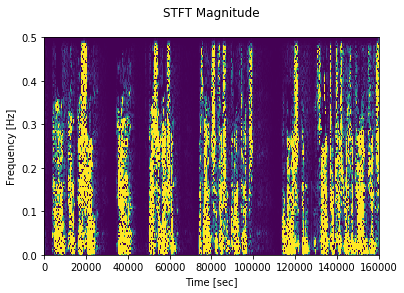

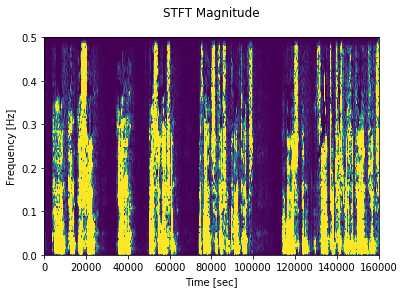

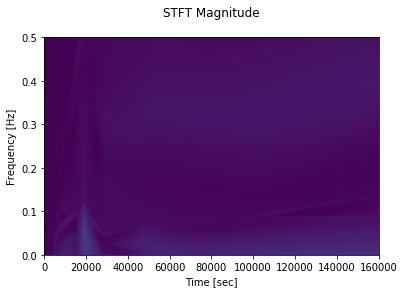

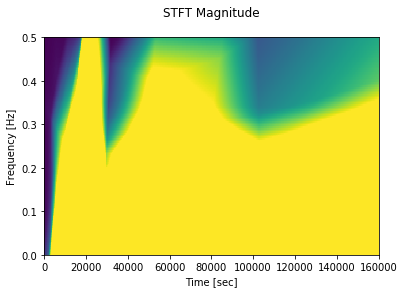

Loss: 4.767155 Mean: 7.875448703765869/-5.250436782836914 Sig: 443.0492858886719/0.10028135031461716: : 998it [15:51:16, 57.19s/it]


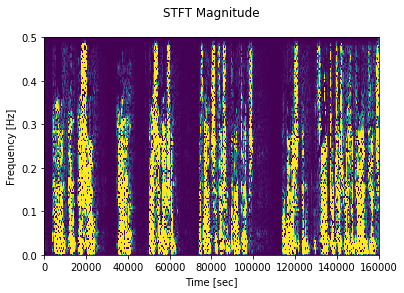

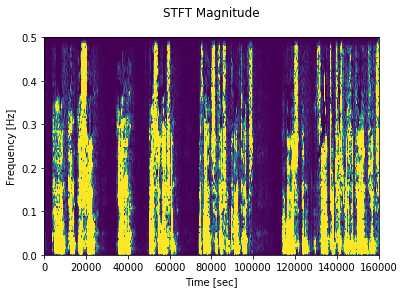

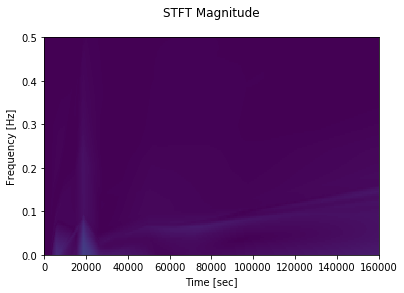

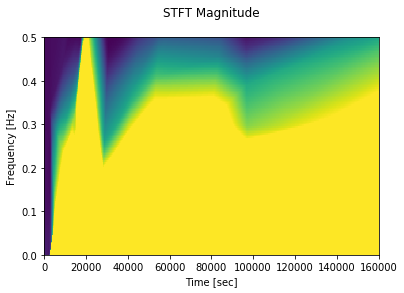

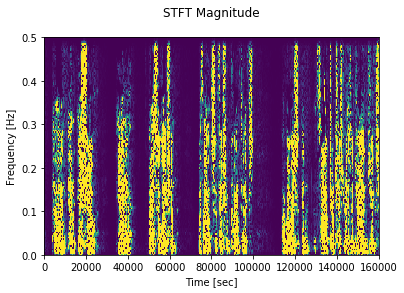

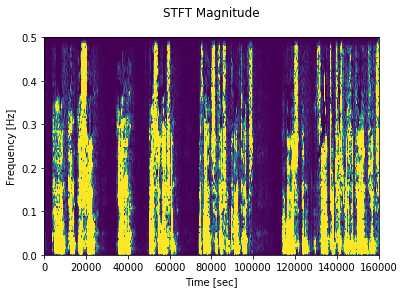

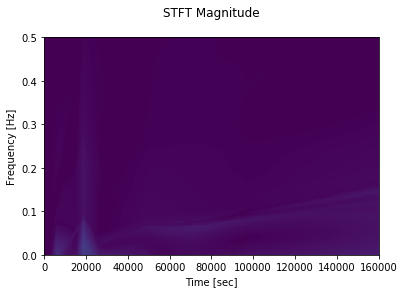

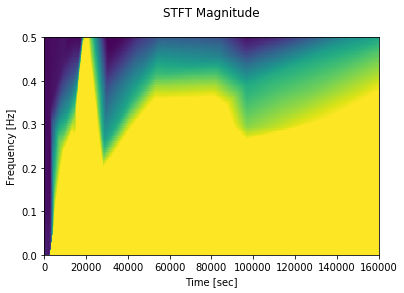

Loss: 4.729606 Mean: 5.029013633728027/-2.0299649238586426 Sig: 447.13909912109375/0.10467757284641266: : 998it [15:32:20, 56.05s/it]


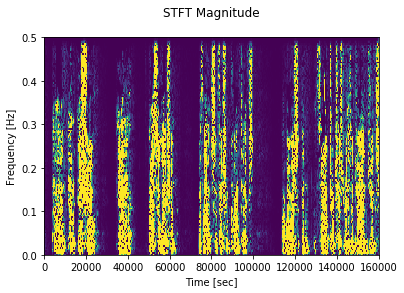

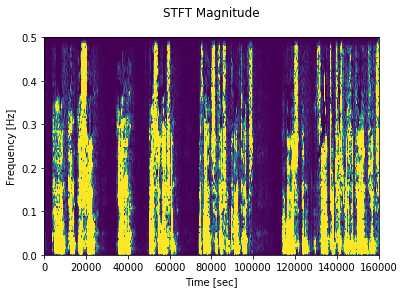

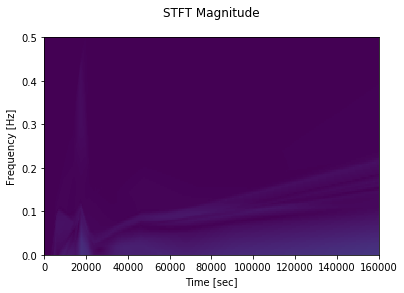

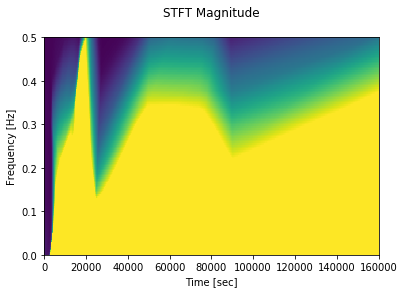

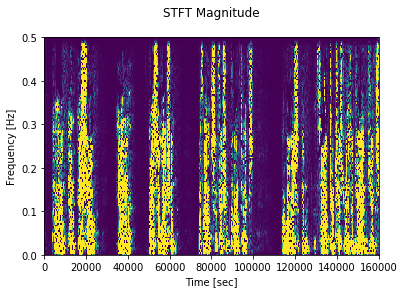

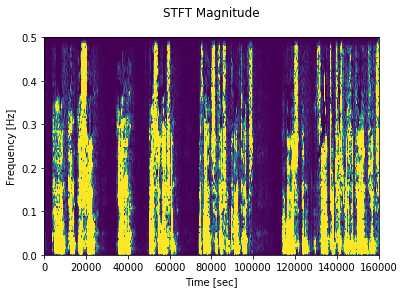

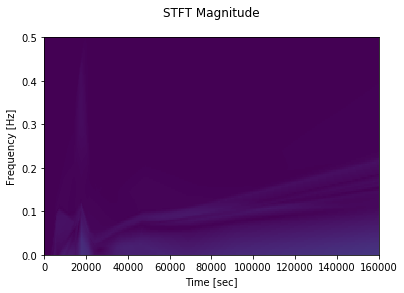

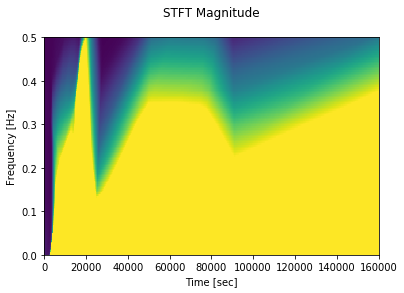

Loss: 4.696419 Mean: 5.748250961303711/-5.623976230621338 Sig: 535.77001953125/0.10039645433425903: : 998it [15:45:23, 56.84s/it]


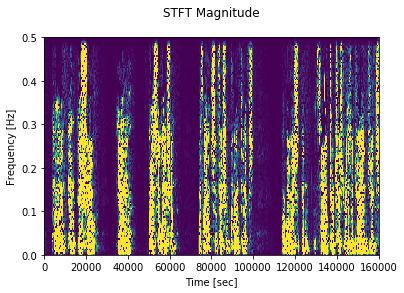

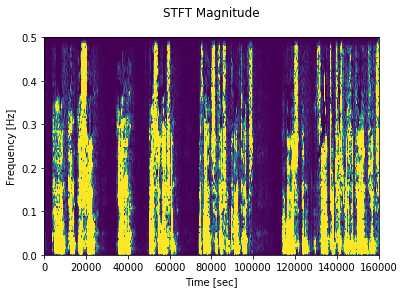

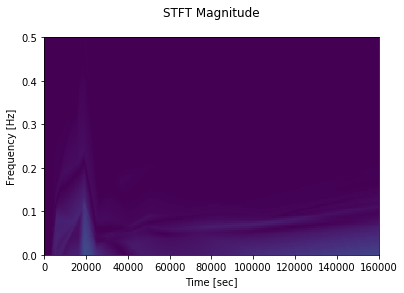

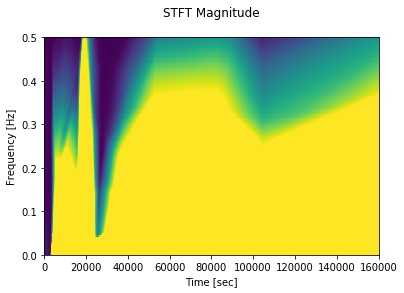

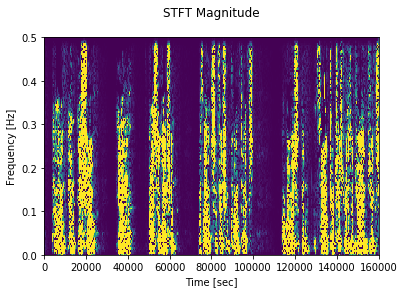

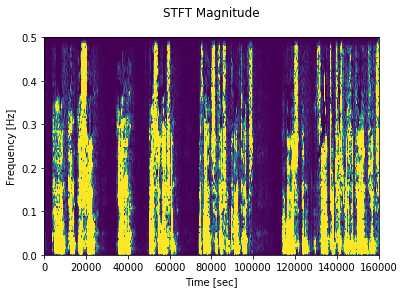

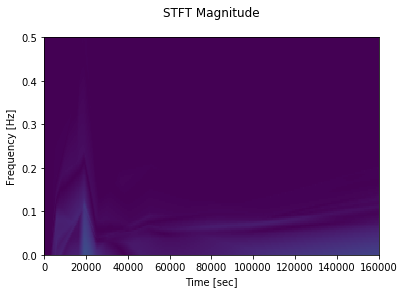

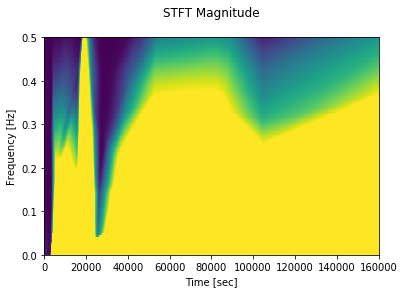

In [8]:
encoder = Encoder().to(device)
decoder = Decoder(m, n).to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))


for epoch in range(1, epochs+1):
    encoder.train()
    decoder.train()
    progress = tqdm(enumerate(train_loader))
    for batch_idx, data in progress:
        f, t, zxx, sample_rate = data
        
        num_context_points = np.random.randint(min_context_points, max_context_points)
        cntx = get_context_points_audio(zxx, context_points=num_context_points)
        cntx = cntx.to(device).float()
        optimizer.zero_grad()
        
        # run the model to get r
        output = encoder(cntx)
        mu_real, sigma_real, mu_imag, sigma_imag = decoder(output)
        
        mu = torch.cat((mu_real, mu_imag))
        sigma = torch.cat((sigma_real, sigma_imag))
        
        # ok, now we need to think about multidimensionally distributed log probability
        log_p = get_log_p(zxx.view(2,m,n).to(device).view(-1).float(), mu, sigma)
                
        
        loss = -log_p.mean()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            progress.set_description('Loss: {:.6f} Mean: {}/{} Sig: {}/{}'.format(loss.item(), mu.max(), mu.min(), sigma.max(), sigma.min()))
    
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for data in test_loader:
            f, t, zxx, sample_rate = data
            cp = int(max_context_points - 2*min_context_points)
            
            cntx = get_context_points_audio(zxx, context_points=cp)
            zxx, cntx = zxx.to(device).float(), cntx.to(device).float()


            output = encoder(cntx)
            mu_real, sigma_real, mu_imag, sigma_imag = decoder(output)

            zxx, cntx = np.array(zxx.float().tolist()), np.array(cntx.float().tolist())


            mu = np.array(mu_real.tolist()) + np.array(mu_imag.tolist())*1j
            sigma = np.array(sigma_real.tolist()) + np.array(sigma_imag.tolist())*1j
            cntx = cntx[0,:,:] + cntx[1,:,:]*1j
            zxx = zxx[0,:,:] + zxx[1,:,:]*1j

            if use_mnist:
                plt.imshow(cntx.reshape(m,n), cmap='gray')
                plt.axis("off")
                plt.show()

                plt.imshow(data.reshape(m,n), cmap='gray')
                plt.axis("off")
                plt.show()

                plt.imshow(mu.detach().reshape(m,n), cmap='gray')
                plt.axis("off")
                plt.title("mean")
                plt.show()

                plt.imshow(sigma.detach().reshape(n,b), cmap='gray')
                plt.axis("off")
                plt.title("variance")
                plt.show()
            else:
                spect.plot_spect(f, t, cntx)
                spect.plot_spect(f, t, zxx)
                spect.plot_spect(f, t, mu.reshape(m,n))
                spect.plot_spect(f, t, sigma.reshape(m,n))
                
                spect.get_istft(mu.reshape(m,n), sample_rate, title="{}mu_output".format(epoch), save=True)
                spect.get_istft(sigma.reshape(m,n), sample_rate, title="{}sigma_output".format(epoch), save=True)                

In [9]:
import pickle

with open("encoder_spect.pkl", "wb") as of:
    pickle.dump(encoder, of)

with open("decoder_spect.pkl", "wb") as of:
    pickle.dump(decoder, of)